# Worksheet 16

Name:  Erwin Pimentel
UID: U97810050

### Topics

- Support Vector Machines (Non-linear case)

## Support Vector Machines

Follow along in class to implement the perceptron algorithm and create an animation of the algorithm.

a) As we saw in class, the form
$$w^T x + b = 0$$
while simple, does not expose the inner product `<x_i, x_j>` which we know `w` depends on, having done the math. This is critical to applying the "kernel trick" which allows for learning non-linear decision boundaries. Let's modify the above algorithm to use the form
$$\sum_i \alpha_i <x_i, x> + b = 0$$

In [2]:
import numpy as np
from PIL import Image as im
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

TEMPFILE = "temp.png"
CENTERS = [[0, 1], [1, 0]]

epochs = 100
lr = .05
expanding_rate = .99
retracting_rate = 1.1

X, labels = datasets.make_blobs(n_samples=10, centers=CENTERS, cluster_std=0.2, random_state=0)
Y = np.array(list(map(lambda x : -1 if x == 0 else 1, labels.tolist())))

alpha_i = np.zeros((len(X),))
b = 0

def snap(x, alpha_i, b, error):
    # create a mesh to plot in
    h = .01  # step size in the mesh
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    meshData = np.c_[xx.ravel(), yy.ravel()]
    cs = np.array([x for x in 'gb'])
    fig, ax = plt.subplots()
    ax.scatter(X[:,0],X[:,1],color=cs[labels].tolist(), s=50, alpha=0.8)

    if error:
        ax.add_patch(plt.Circle((x[0], x[1]), .12, color='r',fill=False))
    else:
        ax.add_patch(plt.Circle((x[0], x[1]), .12, color='y',fill=False))
   
    Z = predict_many(alpha_i, b, meshData)
    Z = np.array([0 if z <=0 else 1 for z in Z]).reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=.5, cmap=plt.cm.Paired)
    fig.savefig(TEMPFILE)
    plt.close()
    return im.fromarray(np.asarray(im.open(TEMPFILE)))

def predict_many(alpha_i, b, Z):
    res = []
    for i in range(len(Z)):
        res.append(predict(alpha_i, b, Z[i]))
    return np.array(res)

def predict(alpha_i, b, x):
    wx = 0
    for j in range(len(X)):
        wx += alpha_i[j] * np.dot(X[j], x)
    return wx + b

images = []
for _ in range(epochs):
    # pick a point from X at random
    i = np.random.randint(0, len(X))
    error = False
    x, y = X[i], Y[i]
    ypred = predict(alpha_i, b, x)
    if (ypred > 0 and y > 0) or (ypred < 0 and y < 0):
        # classified correctly
        if ypred < 1 and ypred > -1:
            # in the street / street is too wide
            alpha_i[i] += y * lr
            alpha_i = alpha_i * retracting_rate           
            b += y * lr * retracting_rate
        else:
            # street is too narrow
            alpha_i = alpha_i * expanding_rate
            b *= expanding_rate
    else:
        # misclassified
        alpha_i[i] += y * lr
        alpha_i = alpha_i * expanding_rate
        b += y * lr * expanding_rate
        
    images.append(snap(x, alpha_i, b, error))

images[0].save(
    'svm_dual.gif',
    optimize=False,
    save_all=True,
    append_images=images[1:],
    loop=0,
    duration=100
)

In [3]:
from IPython.display import Image

Image(url='svm_dual.gif')

Write a configurable kernel function to apply in lieu of the dot product. Try it out on a dataset that is not linearly separable.

In [5]:
def polynomial(x_i, x_j, c, n):
    return (np.dot(x_i, x_j) + c) ** n

def predict(alpha_i, b, x):
    wx = 0
    for j in range(len(X)):
        wx += alpha_i[j] * polynomial(X[j], x, C, N)
    return wx + b

b) Assume we fit an SVM using a polynomial Kernel function and it seems to overfit the data. How would you adjust the tuning parameter `n` of the kernel function?

If an SVM with a polynomial kernel overfits the data, it means that the model is too complex and is capturing noise in the training dataset as if it were a part of the actual pattern. To reduce overfitting, we can decrease the degree of 'n' so that the model becomes simpler and may generalize better to unseen data.

c) Assume we fit an SVM using a RBF Kernel function and it seems to underfit the data. How would you adjust the tuning parameter `sigma` of the kernel function?

If an SVM with an RBF kernel underfits the data, it suggests that the decision boundary is too simple and cannot capture the complexity of the data. To address underfitting, we cna decrease sigma in order to increase the influence of the training samples.

d) Tune the parameter of a specific Kernel function, to fit an SVM (using your code above) to the following dataset:

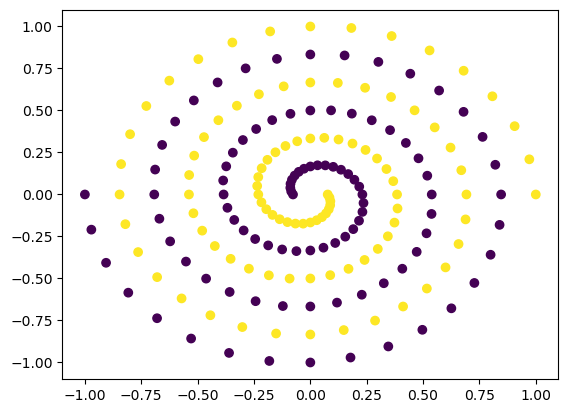

Best parameters: {'C': 0.1, 'gamma': 0.01}


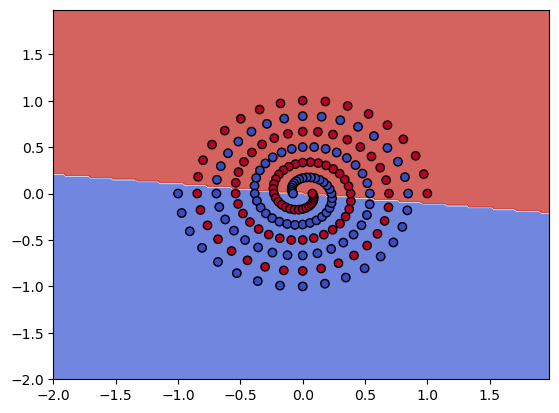

In [12]:
import numpy as np
from PIL import Image as im
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

def plot_decision_boundary(model, X):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = 0.02  # step size in the mesh

    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Predict the function value for the whole grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

# Load your data
data = np.loadtxt("spiral.data")
X, Y = data[:, :2], data[:, 2]

# Visualize the data
plt.scatter(X[:, 0], X[:, 1], c=Y)
plt.show()

# Set up the parameter grid
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [0.01, 0.1, 1, 10, 100]}

# Create a classifier with the RBF kernel
svc = SVC(kernel='rbf')

# Perform grid search with cross-validation
grid_search = GridSearchCV(svc, param_grid, cv=5)
grid_search.fit(X, Y)

# Print the best parameters
print("Best parameters:", grid_search.best_params_)

# Visualize the decision boundary
plt.scatter(X[:, 0], X[:, 1], c=Y)
plot_decision_boundary(grid_search.best_estimator_, X)
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.coolwarm, edgecolors='k')
plt.show()